<a href="https://colab.research.google.com/github/Thomas-D40/deep-learning/blob/main/Recr%C3%A9er_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans l'algorithme qu'on a mis en place, on remarque la répétition d'un pattern:

produit matriciel (W.X) -> ajout du biais -> fonction de non linéarité (sigmoide, reLu, ...)

puis pour la prédiction, on fait produit matriciel, ajout du biais, prédiction et comparaison pour obtenir l'erreur


Ainsi la combinaison: produit + biais + sigmoïde constitue une couche

In [ ]:
import numpy as np

# Boite générique

In [ ]:
class Boite():
  def __init__(self):
    pass

  def forward(self, input):
    self.input = input
    self.output = self.operation()
    return self.output

  def backward(self, derivee_output):
    assert derivee_output.shape == self.output.shape, f"La dérivée de output a un shape {derivee_output.shape} différent du shape de output {self.output.shape}"

    self.derivee_input = self.gradient(derivee_output)
    assert self.derivee_input.shape == self.input.shape, f"La dérivée de output a un shape {self.derivee_input.shape} différent du shape de output {self.input.shape}"
    return self.derivee_input

  def gradient(self, derivee_output):
    pass

  def operation(self):
    pass


# Boite paramétrée

In [ ]:
class BoiteParam():
  def __init__(self, param):
    self.param = param

  def forward(self, input):
    self.input = input
    self.output = self.operation()
    return self.output

  def backward(self, derivee_output):
    assert derivee_output.shape == self.output.shape, f"La dérivée de output a un shape {derivee_output.shape} différent du shape de output {self.output.shape}"

    self.derivee_input = self.gradient(derivee_output)
    assert self.derivee_input.shape == self.input.shape, f"La dérivée de input a un shape {self.derivee_input.shape} différent du shape de output {self.input.shape}"

    self.derivee_param = self.gradient_param(derivee_output)
    assert self.derivee_param.shape == self.param.shape, f"La dérivée de param a un shape {self.derivee_param.shape} différent du shape de param {self.param.shape}"
    return self.derivee_input

  # Sert à la boucle de rétro-propagation
  def gradient(self, derivee_output):
    pass

  def operation(self):
    pass

  # Permet d'update le param
  def gradient_param(self, derivee_output):
    pass

# La classe Dot (produit matriciel)

In [ ]:
class Dot(BoiteParam):
  def __init__(self, weights):
    super().__init__(weights)

  def operation(self):
    return np.dot(self.input, self.param)

  def gradient(self, derivee_output):
    return np.dot(derivee_output, self.param.T)

  def gradient_param(self, derivee_output):
    return np.dot(self.input.T, derivee_output)

  def __repr__(self):
    return f"Dot(params={self.param})"

In [ ]:
X = np.array([[ 2,  3, -2],
       [ 4,  5, -1],
       [-5,  2,  3],
       [ 0,  5,  4]])

In [ ]:
W = np.array([[ 0.49671415],
 [-0.1382643 ],
 [ 0.64768854]])
W.shape

(3, 1)

In [ ]:
np.dot(X, W)

array([[-0.71674168],
       [ 0.64784656],
       [-0.81703373],
       [ 1.89943266]])

In [ ]:
M = Dot(W)
M1 = M.forward(X)

In [ ]:
M

Dot(params=[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]])

In [ ]:
M1

array([[-0.71674168],
       [ 0.64784656],
       [-0.81703373],
       [ 1.89943266]])

In [ ]:
d_out = np.random.randn(4,1)
d_out

array([[-0.53698189],
       [ 0.54084971],
       [ 0.80984894],
       [-0.45864435]])

In [ ]:
M.backward(d_out)

array([[-0.2667265 ,  0.07424543, -0.34779702],
       [ 0.2686477 , -0.07478021,  0.35030216],
       [ 0.40226343, -0.1119732 ,  0.52452988],
       [-0.22781514,  0.06341414, -0.29705869]])

# La classe Add

In [ ]:
import numpy as np

In [ ]:
class Add(BoiteParam):
  def __init__(self, biais):
    super().__init__(biais)

  def operation(self):
    return self.input + self.param

  def gradient(self, derivee_output):
    return np.ones_like(self.input) * derivee_output

  def gradient_param(self, derivee_output):
    r = np.ones_like(self.param) * derivee_output
    return r.sum(axis=0).reshape(1, self.param.shape[1])

  def __repr__(self):
    return f"Add(params={self.param})"

In [ ]:
B = np.random.randn(1,1)
B

array([[-1.05073527]])

In [ ]:
b = Add(biais=B)
B1 = b.forward(M1)

In [ ]:
d_out = np.random.randn(4,1)

In [ ]:
b.backward(d_out)

array([[ 1.66430004],
       [-0.00440024],
       [-1.21955515],
       [ 0.66683853]])

# La classe Sigmoide

In [ ]:
class Sigmoid(Boite):
  def __init__(self):
    super().__init__()

  def operation(self):
    return 1 / (1 + np.exp(-self.input))

  def gradient(self, derivee_output):
    return derivee_output * (1 - self.output) * self.output

  def __repr__(self):
    return f"Sigmoid()"

In [ ]:
sig = Sigmoid()

In [ ]:
S1 = sig.forward(B1)

In [ ]:
sig.backward(d_out)

array([[ 0.20734232],
       [-0.0010566 ],
       [-0.14134354],
       [ 0.13995766]])

# La classe Loss

In [ ]:
class Loss():

  def __init__(self):
    pass

  def forward(self, prediction, target):
    assert prediction.shape == target.shape, f"Prediction shape {prediction.shape}  Target shape {target.shape}"
    self.prediction = prediction
    self.target = target
    loss = np.mean((self.target - self.prediction) ** 2)
    return loss

  def backward(self):

    self.loss_derivee = -2 * (self.target - self.prediction)
    assert self.loss_derivee.shape == self.prediction.shape, f"La derivee du loss un shape {self.loss_derivee.shape } different du shape de Prediction : {self.prediction.shape}"

    return self.loss_derivee

In [ ]:
Y= np.random.randn(4,1)

In [ ]:
mse = Loss()

In [ ]:
mse.forward(S1, Y)

1.1585946735756902

In [ ]:
mse.backward()

array([[ 3.47878311],
       [ 2.20383692],
       [-1.21439904],
       [-0.32236724]])

# La classe Dense

Il s'agit d'une classe représentant une couche de neuronnes ou layers.
Néanmoins le choix de dense vient du fait que chaque neuronne de la couche va recevoir l'intégralité des caractéristiques pour effectuer son propre calcul avec son W et générer son résultat

In [ ]:
class Dense():
  def __init__(self, neurons, activation=None):
    self.neurons = neurons
    self.activation = activation
    self.params = []
    self.suite = []
    self.initialisation = False
    self.derivee_params = []

  def build(self, input):
    # Weight initialisation
    np.random.seed(42)

    self.weight = np.random.randn(input.shape[1], self.neurons) # input.shape[1] permet de prendre le second élément du shape. Exemple: shape (1000,5) => 5
    self.biais = np.random.randn(1, self.neurons)

    self.params = [self.weight, self.biais]

    # Construction de la suite d'opérations
    self.suite = [Dot(self.params[0]), Add(self.params[1])]
    if self.activation:
      self.suite.append(self.activation)


  def forward(self, input):
    if self.initialisation is False:
        self.build(input)
        self.initialisation = True

    for layer in self.suite:
      input = layer.forward(input)

    self.output = input
    return self.output

  def backward(self, derivee_output):
    assert derivee_output.shape == self.output.shape, f"La dérivée de output a un shape {derivee_output.shape} différent du shape de output {self.output.shape}"
    for layer in reversed(self.suite):
      derivee_output = layer.backward(derivee_output)

    self.derivee_input = derivee_output

    self.get_layer_gradients()

    return self.derivee_input

  def get_layer_gradients(self):
    self.derivee_params = []

    for layer in self.suite:
      if issubclass(layer.__class__, BoiteParam):
        self.derivee_params.append(layer.derivee_param)



  def __repr__(self):
    r = f"Dense(neurons={self.neurons}"
    if self.activation:
      r += f", activation={self.activation}"
    r += ")"
    return r




In [ ]:
sigmoid = Sigmoid()

In [ ]:
couche = Dense(3, sigmoid)
couche

Dense(neurons=3, activation=Sigmoid())

In [ ]:
couche.forward(X)

array([[0.95010503, 0.0484631 , 0.74387077],
       [0.99980944, 0.04951595, 0.80593564],
       [0.99710736, 0.88714466, 0.00375513],
       [0.99999948, 0.80776527, 0.02890774]])

In [ ]:
d_out_2 = np.random.randn(4,3)

In [ ]:
couche.backward(d_out_2)

array([[-0.19496212,  0.11507656,  0.10469318],
       [ 0.03837104, -0.00050921, -0.05982562],
       [ 0.02180077,  0.02783634, -0.11522417],
       [-0.0273546 ,  0.00690899,  0.02682393]])

In [ ]:
couche.derivee_param

[array([[ 0.03560711,  0.33986059, -0.4881048 ],
        [ 0.02863679, -0.73339731, -0.92919593],
        [-0.03069098, -0.15812445,  0.46460417]]),
 array([[ 0.0087441 , -0.26681046, -0.31400676]])]

# Model

Cette dernière sera constitué d'une liste de Couches / Layers / Dense

In [ ]:
from copy import deepcopy

class Model():
  def __init__(self, layers):
    self.layers = layers
    self.compiled = False

  def forward(self, input):
    for layer in self.layers:
      input = layer.forward(input)

    self.output = input
    return self.output

  def backward(self, loss_derivee):
    assert(loss_derivee.shape == self.output.shape), f"La dérivée de loss un shape {loss_derivee.shape } different du shape de Prediction : {self.output.shape}"

    for layer in reversed(self.layers):
      loss_derivee = layer.backward(loss_derivee)

    self.loss_derivee = loss_derivee

    return self.loss_derivee

  def get_params(self):
    for layer in self.layers:
      yield from layer.params

  def get_derivee_params(self):
    for layer in self.layers:
      yield from layer.derivee_params

  def update(self):
    # Quand on a deux listes [1,2,3] & [4,5,6] et que l'on souhaite faire des opérations sur les couples d'éléments
    # en fonction de leur position, on peut faire une boucle for a, b in zip(list1,list2)
    for param, derivee_param in zip(self.get_params(), self.get_derivee_params()):
        param -= self.learning_rate * derivee_param

  def compile(self, loss, learning_rate):
    self.loss = loss
    self.learning_rate = learning_rate
    self.compiled = True

  def fit(self, X, Y, epochs, validation_data=None):

    if (validation_data):
      assert len(validation_data) == 2
      assert validation_data[0].shape[1] == X.shape[1]
      assert validation_data[1].shape[1] == Y.shape[1]

    self.history = {"loss": []}
    if validation_data:
      self.history["val_loss"] = []

    if self.compiled is False:
      raise NotImplementedError("Absence de loss et/ou learning rate: Compilez")

    for epoch in range(epochs):
      # forward
      predictions = model.forward(X)
      loss = self.loss.forward(predictions, Y)

      log = f'Epoch {epoch + 1}... loss: {loss}'

      if (validation_data):
        #val_loss
        val_predictions = self.forward(validation_data[0])
        val_loss = self.loss.forward(val_predictions, validation_data[1])
        log += f" - val_loss: {val_loss}"
        self.history['val_loss'].append(val_loss)


      self.history['loss'].append(loss)
      print(log)

      # backward
      loss_derivee = self.loss.backward()
      self.backward(loss_derivee)

      #update
      self.update()

  def save_model(self, file):
    model_saved = deepcopy(self)

    import pickle
    with open(file, "wb") as f:
      pickle.dump(model_saved, f)
    return model_saved

  def __repr__(self):
    r = "Model(\n"
    for layer in self.layers:
      r += f"  {layer},\n"
    r += ")"
    return r

In [ ]:
model = Model([Dense(neurons=3, activation=sigmoid), Dense(neurons=1)])

In [ ]:
model.forward(X)

array([[2.47005633],
       [2.53479834],
       [1.89807891],
       [1.92678186]])

In [ ]:
loss_derivee = np.random.randn(4,1)

In [ ]:
model.backward(loss_derivee)

array([[ 0.75179581,  0.06877772, -0.20839432],
       [ 0.43077661, -0.1427145 , -0.33915957],
       [ 0.00970781,  0.01123761, -0.02198122],
       [ 0.03141557,  0.00164171, -0.05329121]])

# Update des paramètres

In [ ]:
for p in params:
  params[p] = params[p] - learning_rate * grads[p]

NameError: name 'params' is not defined

In [ ]:
M.derivee_input

array([[-0.2667265 ,  0.07424543, -0.34779702],
       [ 0.2686477 , -0.07478021,  0.35030216],
       [ 0.40226343, -0.1119732 ,  0.52452988],
       [-0.22781514,  0.06341414, -0.29705869]])

In [ ]:
couche.derivee_param

[array([[ 0.03560711,  0.33986059, -0.4881048 ],
        [ 0.02863679, -0.73339731, -0.92919593],
        [-0.03069098, -0.15812445,  0.46460417]]),
 array([[ 0.0087441 , -0.26681046, -0.31400676]])]

In [ ]:
model.get_params()

[[array([[ 0.49671415, -0.1382643 ,  0.64768854],
         [ 1.52302986, -0.23415337, -0.23413696],
         [ 1.57921282,  0.76743473, -0.46947439]]),
  array([[ 0.54256004, -0.46341769, -0.46572975]])],
 [array([[ 0.49671415],
         [-0.1382643 ],
         [ 0.64768854]]),
  array([[1.52302986]])]]

In [ ]:
model.get_derivee_params()

[[array([[-0.02242822,  0.11838461, -0.17179535],
         [-0.01212565, -0.11400805, -0.12785598],
         [ 0.01783758, -0.13599864,  0.14880161]]),
  array([[-0.00327309, -0.03532094, -0.03483333]])],
 [array([[ 1.88551641],
         [ 1.99795603],
         [-0.33476421]]),
  array([[1.87835721]])]]

In [ ]:
model = Model([Dense(neurons=2, activation=sigmoid), Dense(neurons=1)])

# Forward
P = model.forward(X)
mse = Loss()
loss = mse.forward(P, Y)
print(loss)
loss_derivee = mse.backward()
model.backward(loss_derivee)




2.4190226969585624


array([[ 0.00904565,  0.00697401, -0.00341699],
       [ 0.00075822,  0.00073575, -0.00031298],
       [-0.00225069, -0.00274806,  0.00102818],
       [ 0.00131933,  0.00168335, -0.00061544]])

In [ ]:
P

array([[-3.21744502],
       [-3.22879276],
       [-2.67886602],
       [-3.21025485]])

In [ ]:
model.update()

# Forward
P = model.forward(X)
mse = Loss()
loss = mse.forward(P, Y)
print(loss)

1.0961851280668777


# Test de la fonction Fit

In [ ]:
model = Model([Dense(neurons=2, activation=sigmoid), Dense(neurons=1)])
mse = Loss()
model.compile(loss=mse, learning_rate=0.001)

model.fit(X, Y, 10, validation_data=(X, Y))

Epoch 1... loss: 2.4190226969585624 - val_loss: 2.4190226969585624
Epoch 2... loss: 2.361235373705194 - val_loss: 2.361235373705194
Epoch 3... loss: 2.3059284996240508 - val_loss: 2.3059284996240508
Epoch 4... loss: 2.2529942673007994 - val_loss: 2.2529942673007994
Epoch 5... loss: 2.2023296734102074 - val_loss: 2.2023296734102074
Epoch 6... loss: 2.1538362924945016 - val_loss: 2.1538362924945016
Epoch 7... loss: 2.1074200625693047 - val_loss: 2.1074200625693047
Epoch 8... loss: 2.0629910818298156 - val_loss: 2.0629910818298156
Epoch 9... loss: 2.020463415784185 - val_loss: 2.020463415784185
Epoch 10... loss: 1.979754914190517 - val_loss: 1.979754914190517


# Comparaison TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

lr = Sequential([Dense(2, activation='sigmoid'), Dense(1)]) # Ici, on indique qu'on fait une régression linéaire suivi d'une non-linéarité qu'on appelle "relu"
lr.compile(optimizer=SGD(learning_rate=0.01), loss='mse')
history = lr.fit(X, Y, epochs=10)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 1.8460
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.7943
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.7423
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.6901
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.6379
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.5858
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.5340
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.4828
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.4324
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.3830


# Test de notre tensorFlow maison sur les données de Boston

In [ ]:
import pandas as pd
import numpy as np

data_url = "https://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[0::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]


# Scaling the data
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)
target = target.reshape((-1,1))


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

# Régression linéaire simple

In [ ]:
model = Model([Dense(neurons=1)])
mse = Loss()
model.compile(loss=mse, learning_rate=0.001)

model.fit(X_train, y_train, 30, validation_data=(X_test, y_test))

Epoch 1... loss: 712.6428214565543 - val_loss: 690.1012266714894
Epoch 2... loss: 384.6067061207894 - val_loss: 354.5620227037463
Epoch 3... loss: 203.17607886344868 - val_loss: 190.87699998613857
Epoch 4... loss: 129.8854372736156 - val_loss: 109.61440143265463
Epoch 5... loss: 75.4750866052943 - val_loss: 68.61422600292656
Epoch 6... loss: 61.01405116983065 - val_loss: 47.56962178675052
Epoch 7... loss: 41.401102465579584 - val_loss: 36.551189456267814
Epoch 8... loss: 40.21867134089386 - val_loss: 30.643487989830945
Epoch 9... loss: 31.61931060669679 - val_loss: 27.38417415335182
Epoch 10... loss: 32.95826264341764 - val_loss: 25.523989638374474
Epoch 11... loss: 28.552297953823984 - val_loss: 24.419928431436126
Epoch 12... loss: 29.977546662090358 - val_loss: 23.73545808898344
Epoch 13... loss: 27.488196501032757 - val_loss: 23.291004429972688
Epoch 14... loss: 28.559623198517112 - val_loss: 22.988592287122678
Epoch 15... loss: 27.07412327095996 - val_loss: 22.773405029787114
Epoch

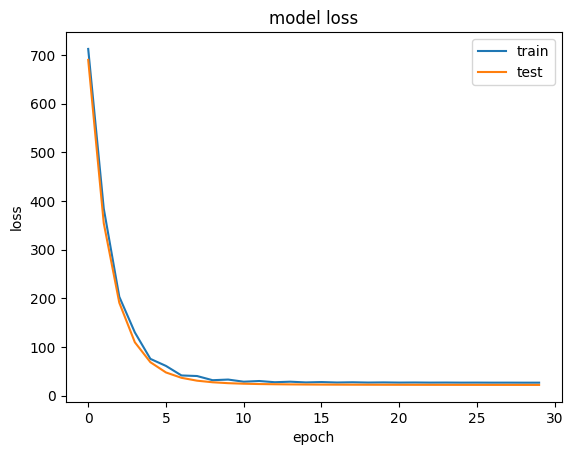

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(history):
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')

plot_learning_curve(model.history)



# Réseau de neuronnes simple

In [ ]:
sigmoid = Sigmoid()
model = Model([Dense(neurons=3, activation=sigmoid), Dense(neurons=1)])
mse = Loss()
model.compile(loss=mse, learning_rate=0.001)

model.fit(X_train, y_train, 150, validation_data=(X_test, y_test))

Epoch 1... loss: 508.91224748785964 - val_loss: 492.67186829783213
Epoch 2... loss: 137.38140465767262 - val_loss: 135.78255841378223
Epoch 3... loss: 58.09006555713163 - val_loss: 64.8010463550256
Epoch 4... loss: 47.61559936226534 - val_loss: 55.11818769534138
Epoch 5... loss: 42.56496739754174 - val_loss: 48.156141690887274
Epoch 6... loss: 38.61640401696442 - val_loss: 42.80636493269119
Epoch 7... loss: 35.78384493778803 - val_loss: 37.94238804713059
Epoch 8... loss: 34.74412067853009 - val_loss: 36.89560671942957
Epoch 9... loss: 39.22353213648677 - val_loss: 41.524839423947995
Epoch 10... loss: 34.37956478770616 - val_loss: 35.879023810029175
Epoch 11... loss: 38.9139017759205 - val_loss: 39.70779845178775
Epoch 12... loss: 31.43737018464002 - val_loss: 32.2476291848375
Epoch 13... loss: 32.91579547799913 - val_loss: 31.572868881112065
Epoch 14... loss: 29.119571262416624 - val_loss: 28.841441878629595
Epoch 15... loss: 30.70157693156555 - val_loss: 28.546850481021526
Epoch 16...

In [ ]:
model.history

{'loss': [508.91224748785964,
  137.38140465767262,
  58.09006555713163,
  47.61559936226534,
  42.56496739754174,
  38.61640401696442,
  35.78384493778803,
  34.74412067853009,
  39.22353213648677,
  34.37956478770616,
  38.9139017759205,
  31.43737018464002,
  32.91579547799913,
  29.119571262416624,
  30.70157693156555,
  27.713217741835077,
  29.83207140028684,
  26.871036652122623,
  29.438919337934344,
  25.967510021510517,
  27.911282483115553,
  24.749143744465886,
  25.825416124584976,
  23.72529691166187,
  24.67021916278446,
  23.43004518590617,
  25.452835939279176,
  23.844015387887904,
  27.17011764814208,
  23.679205446400168,
  25.650040854973838,
  22.751650580928132,
  23.432706659735587,
  21.883738555475905,
  22.11238732136586,
  21.589903899029043,
  21.81701837226122,
  21.700457587059482,
  21.989491900512945,
  21.823127343101323,
  21.938448745899258,
  21.711697306199646,
  21.519843871941845,
  21.46662452699844,
  21.064219550773625,
  21.276700374954597,
 

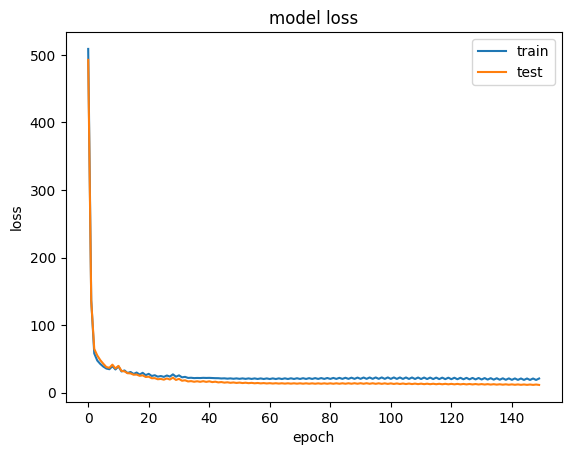

In [ ]:
plot_learning_curve(model.history)

# Deep Neural Network

In [ ]:
sigmoid = Sigmoid()
model = Model([
    Dense(neurons=13, activation=sigmoid),
    Dense(neurons=1)
    ])
mse = Loss()
model.compile(loss=mse, learning_rate=0.0001)

model.fit(X_train, y_train, 150, validation_data=(X_test, y_test))

Epoch 1... loss: 610.896601804464 - val_loss: 593.0093191051104
Epoch 2... loss: 476.7263688486979 - val_loss: 462.53453186232235
Epoch 3... loss: 374.49315155204584 - val_loss: 363.59853096114017
Epoch 4... loss: 295.2869351438448 - val_loss: 287.339669735567
Epoch 5... loss: 233.6227059349568 - val_loss: 228.3410275679773
Epoch 6... loss: 185.82537431743373 - val_loss: 182.97425245132246
Epoch 7... loss: 149.17284075942626 - val_loss: 148.49777751706102
Epoch 8... loss: 121.44200202078713 - val_loss: 122.64115507856712
Epoch 9... loss: 100.71908888172976 - val_loss: 103.45344051491342
Epoch 10... loss: 85.3614410871093 - val_loss: 89.27493887597569
Epoch 11... loss: 74.01287257568117 - val_loss: 78.75316738603973
Epoch 12... loss: 65.60810719410529 - val_loss: 70.84986739562248
Epoch 13... loss: 59.3474631470467 - val_loss: 64.81944526343489
Epoch 14... loss: 54.64823490424348 - val_loss: 60.15389129576038
Epoch 15... loss: 51.087584451417705 - val_loss: 56.503897320630166
Epoch 16..

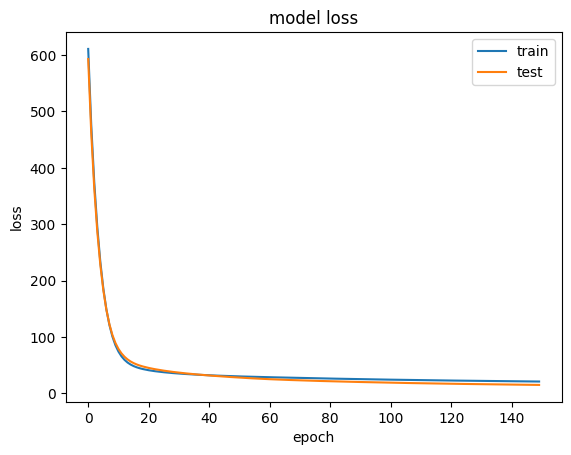

In [ ]:
plot_learning_curve(model.history)

# Sauvegarder le modèle

In [ ]:
model.save_model("model.file")

Model(
  Dense(neurons=13, activation=Sigmoid()),
  Dense(neurons=1),
)

In [ ]:
import pickle

def load_model(file):
  with open(file, "rb") as f:
    model_loaded = pickle.load(f)
  return model_loaded

In [ ]:
model_charge = load_model("model.file")